### importing the libraries

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
import numpy as np # linear algebra
import pandas as pd
import os
print(os.listdir("/content/drive/MyDrive/Fall 2021/CSE498R/Dataset/Strokefaces"))


['Traning Set', 'Validation Set', 'Test Set']


In [3]:
import time
import pandas as pd
import os,shutil,math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import ImageDraw
from glob import glob


from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [4]:
train_data_dir = '/content/drive/MyDrive/Fall 2021/CSE498R/Dataset/Strokefaces/Traning Set'
img_width, img_height = 299, 299 
batch_size = 32
validation_dir = '/content/drive/MyDrive/Fall 2021/CSE498R/Dataset/Strokefaces/Validation Set'


### Image Augmentation

In [5]:
image_datagen = ImageDataGenerator(
    rescale=1./255, 
    vertical_flip = True,
    horizontal_flip = True,
    rotation_range=20,
    shear_range=0.05,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
    #channel_shift_range=0.1
)
train_gen = image_datagen.flow_from_directory(
        train_data_dir, 
        target_size=(img_height, img_width), 
        batch_size=batch_size, 
        class_mode="categorical", 
        subset="training")
valid_gen = image_datagen.flow_from_directory(
        validation_dir, 
        target_size=(img_height, img_width), 
        batch_size=batch_size, 
        class_mode="categorical", 
        subset="validation")

Found 1707 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


### Hyperparameters

In [6]:
# Hyperparameters
second_dense_512 = [0, 1]
dropout = [0, 1]

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
print('Loaded model!')

87924736/87910968 [==============================] - 0s 0us/step
Loaded model!


In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:
for layer in base_model.layers:
    layer.trainable = False 
        
for dense2 in second_dense_512:
    for drop in dropout:
        
        NAME = "strokefaces-inception-dense{}-drop{}-{}".format(dense2, drop, int(time.time()))
        print(NAME)
        logdir = "logs/strokefaces-inception/{}/".format(NAME)
        
        # Callbacks
        checkpoint = ModelCheckpoint(
            '{}base.model'.format(logdir),
            monitor='val_loss',
            mode='min',
            save_weights_only=True,
            save_best_only = True,
            verbose = 1)
        tensorboard = TensorBoard(
            log_dir = logdir,
            histogram_freq=0,
            batch_size=batch_size,
            write_graph=True,
            write_grads=True,
            write_images=False,
        )

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        if drop == 1 : x = Dropout(0.3)(x)
        if dense2 == 1 : 
            x = Dense(512)(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            if drop == 1 : x = Dropout(0.3)(x)
        
        predictions = Dense(2, activation='softmax')(x)
        
        model = Model(base_model.input, predictions)
        
        
        model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

strokefaces-inception-dense0-drop0-1653112495
strokefaces-inception-dense0-drop1-1653112495
strokefaces-inception-dense1-drop0-1653112495
strokefaces-inception-dense1-drop1-1653112496


In [9]:
history = model.fit(
            train_gen,
            steps_per_epoch = train_gen.n // train_gen.batch_size, #normalde len(X_train) / batch_size,
            epochs= 10,
            validation_data = valid_gen,
            validation_steps=valid_gen.n // valid_gen.batch_size, # normalde len(X_valid) / batch_size,
            verbose=1,
            callbacks=[tensorboard])
       

Epoch 1/10
53/53 [==============================] - 277s 5s/step - loss: 0.2136 - accuracy: 0.9236 - val_loss: 0.1547 - val_accuracy: 0.9583
Epoch 2/10
53/53 [==============================] - 39s 730ms/step - loss: 0.1338 - accuracy: 0.9493 - val_loss: 0.1659 - val_accuracy: 0.9479
Epoch 3/10
53/53 [==============================] - 39s 728ms/step - loss: 0.1213 - accuracy: 0.9528 - val_loss: 0.0692 - val_accuracy: 0.9896
Epoch 4/10
53/53 [==============================] - 38s 721ms/step - loss: 0.1000 - accuracy: 0.9654 - val_loss: 0.0533 - val_accuracy: 0.9896
Epoch 5/10
53/53 [==============================] - 41s 765ms/step - loss: 0.0909 - accuracy: 0.9707 - val_loss: 0.0874 - val_accuracy: 0.9479
Epoch 6/10
53/53 [==============================] - 38s 723ms/step - loss: 0.0917 - accuracy: 0.9666 - val_loss: 0.2248 - val_accuracy: 0.9167
Epoch 7/10
53/53 [==============================] - 38s 721ms/step - loss: 0.0745 - accuracy: 0.9743 - val_loss: 0.2431 - val_accuracy: 0.9271
E

### **Result**

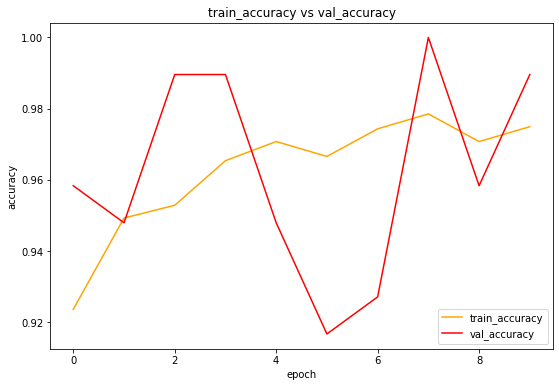

In [10]:
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(6)
plt.plot(history.history['accuracy'], color='orange')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('train_accuracy vs val_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc=4)
plt.show()

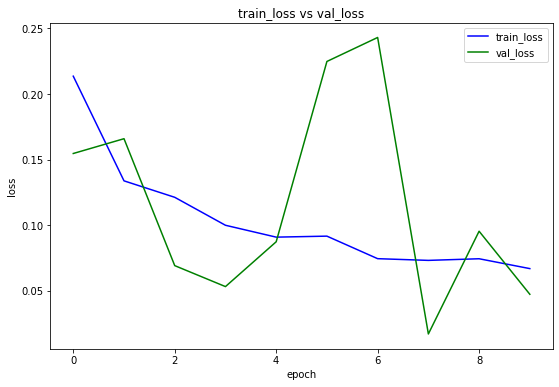

In [11]:
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(6)
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='green')
plt.title('train_loss vs val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [12]:
from keras.models import load_model
from tensorflow import keras

save_model = model.save("inceptionV3.h5")